# **1. PERKENALAN**

---
# <center>**CreditGuide: Your Trustworthy Defaulter Detector**</center>


#### <center>by Catherine Helenna Mulyadi</center>

---

Tujuan dari program ini adalah untuk membuat model klasifikasi default_payment_next_month berdasarkan dataset yang disediakan. Dataset yang akan digunakan berasal dari Google BigQuery Public Dataset dengan tabel credit_card_default. Dataset dapat diakses dengan membuka tab `bigquery-public-data` => `ml_datasets` => `credit_card_default`.

Di dalam tabel ini, terdapat beberapa informasi penting terkait informasi transaksi yang dilakukan oleh pengguna kartu kredit. Informasi tersebut meliputi sex, limit_balance, education_level,marital_status, tingkat payment delay (pay_angka), jumlah amount of bill statement (amt), dan default_payment_next_month (dinyatakan tidak membayar tagihan kredit tepat waktu atau tidak).

Informasi tambahan berkaitan default payment: bila nasabah dinyatakan default oleh bank, maka nasabah dapat dikenakan penalti pembayaran tambahan, peningkatan bunga utang, nilai negatif pada skor kredit (jadi makin sulit untuk meminjam uang), dan penyitaan aset.

---


### <center>**Informasi mengenai data tiap kolom dari dataset**</center>
---

- limit_balance	(Amount of given credit in NT dollars (includes individual and family/supplementary credit))
- sex	(Gender (1=male, 2=female))
- education_level	(Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown))
- marital_status (Marital status (1=married, 2=single, 3=others))
- age	(Age in years)
- pay_0 (Repayment status in September, 2005 (-1=pay duly=> atau sesuai tenggat waktu, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above))
- pay_2	(Repayment status in August, 2005 (scale same as above))
- pay_3	(Repayment status in July, 2005 (scale same as above))
- pay_4	(Repayment status in June, 2005 (scale same as above))
- pay_5	(Repayment status in May, 2005 (scale same as above))
- pay_6	(Repayment status in April, 2005 (scale same as above))
- bill_amt_1	(Amount of bill statement in September, 2005 (NT dollar))
- bill_amt_2	(Amount of bill statement in August, 2005 (NT dollar))
- bill_amt_3	(Amount of bill statement in July, 2005 (NT dollar))
- bill_amt_4	(Amount of bill statement in June, 2005 (NT dollar))
- bill_amt_5	(Amount of bill statement in May, 2005 (NT dollar))
- bill_amt_6	(Amount of bill statement in April, 2005 (NT dollar))
- pay_amt_1	(Amount of previous payment in September, 2005 (NT dollar))
- pay_amt_2	(Amount of previous payment in August, 2005 (NT dollar))
- pay_amt_3	(Amount of previous payment in July, 2005 (NT dollar))
- pay_amt_4	(Amount of previous payment in June, 2005 (NT dollar))
- pay_amt_5	(Amount of previous payment in May, 2005 (NT dollar))
- pay_amt_6	(Amount of previous payment in April, 2005 (NT dollar))
- default_payment_next_month	Default payment (1=yes, 0=no)


======================================================================================================================================================================================================================================

# 2. **QUERY SQL**

## Proses Pengambilan Data Menggunakan Big Query

```sql
----------------------------------------------------------------------
--                INISIASI KONEKSI KE BIG QUERY
----------------------------------------------------------------------
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id_akun = "project1-sql-ngc-6" -- menggunakan project id sendiri
client = bigquery.Client(project=project_id_akun)

----------------------------------------------------------------------
--    QUERY UNTUK PENGAMBILAN DATA SESUAI FORMAT YANG DIMINTA
----------------------------------------------------------------------

df = client.query('''
SELECT
  CAST(sex AS INTEGER) AS sex,
  CAST(education_level AS INTEGER) AS education_level,
  CAST(marital_status AS INTEGER) AS marital_status,
  limit_balance,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST(pay_5 AS FLOAT64) AS pay_5,
  CAST(pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST(default_payment_next_month AS INTEGER) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 54000
WHERE ''').to_dataframe()
```

## Query Untuk Menunjukkan Data 10 teratas dan 10 terbawah

```sql
--Mengambil data 10 teratas dan terbawah
first_last_rows = ('''WITH numbered_rows AS (
    SELECT
        *,
        ROW_NUMBER() OVER () AS row_number,
        COUNT(*) OVER () AS sum_rows
    FROM `bigquery-public-data.ml_datasets.credit_card_default`
)
SELECT *
FROM numbered_rows
WHERE row_number <= 10
   OR row_number > (sum_rows - 10);''')


--Menunjukkan hasil dalam bentuk dataframe
first_last_rows_show = client.query(first_last_rows).to_dataframe()
first_last_rows_show

```

# 3. **IMPORT LIBRARIES**

In [2]:
# untuk EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# untuk feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# for dimensionality reduction
from sklearn.decomposition import PCA

# for data balancing
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC

# untuk model training
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# untuk model evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# untuk model saving
import pickle

# 4.**DATA LOADING**

In [3]:
# read the csv file
main_data = pd.read_csv('client_data.csv')

# show data
main_data

,sex,education_level,marital_status,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,1,6,1,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,1,4,1,200000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,2,6,2,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,2,4,2,260000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,1,4,2,150000.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,2,3,2,80000.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,2,3,1,50000.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,2,2,1,450000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,2,2,1,50000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


In [4]:
# check the general information of the data
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sex                         2965 non-null   int64  
 1   education_level             2965 non-null   int64  
 2   marital_status              2965 non-null   int64  
 3   limit_balance               2965 non-null   float64
 4   pay_0                       2965 non-null   float64
 5   pay_2                       2965 non-null   float64
 6   pay_3                       2965 non-null   float64
 7   pay_4                       2965 non-null   float64
 8   pay_5                       2965 non-null   float64
 9   pay_6                       2965 non-null   float64
 10  bill_amt_1                  2965 non-null   float64
 11  bill_amt_2                  2965 non-null   float64
 12  bill_amt_3                  2965 non-null   float64
 13  bill_amt_4                  2965 

In [4]:
main_data['pay_0'].unique()

array([ 0.,  2.,  1., -1., -2.,  3.,  4.,  5.,  6.,  7.,  8.])

### **INSIGHT:**
- There are 2965 data with 23 columns. Each column has no missing data.
- There are 11 unique values in pay_0; there is no description about the meaning of 0 and -2.

# 5. **EXPLORATORY DATA ANALYSIS (EDA)**

### **Grouping jumlah nasabah pengguna kartu kredit berdasarkan gender**
- Tujuan: Membandingkan apakah wanita / pria memiliki pemakaian kartu kredit lebih banyak atau tidak
- Metode: Menggunakan bar graph.

In [9]:
# membuat dataframe baru

customer_gender = pd.DataFrame(main_data.groupby('sex')['sex'].value_counts().reset_index())

customer_gender

,sex,count
0,1,1163
1,2,1802


In [10]:
# mengubah nama label dari count => number_of_customers
customer_gender.rename(columns={'count':'number_of_customers'},inplace = True)

customer_gender

,sex,number_of_customers
0,1,1163
1,2,1802


In [11]:
# mengubah nilai angka pada sex (gender) menjadi string

customer_gender['sex'] = customer_gender['sex'].replace(1,'Male')
customer_gender['sex'] = customer_gender['sex'].replace(2,'Female')

customer_gender

,sex,number_of_customers
0,Male,1163
1,Female,1802


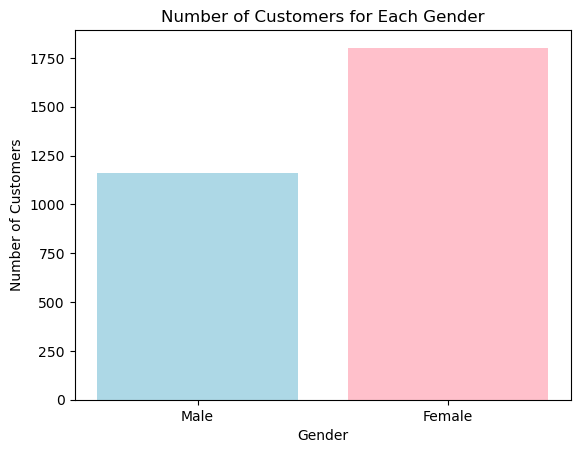

In [12]:
# mendefinisikan values x dan y
x_values = customer_gender['sex']
y_values = customer_gender['number_of_customers']

# Definisikan warna berdasarkan gender
colors = ['lightblue' if s == 'Male' else 'pink' for s in customer_gender['sex']]

# plotting dengan bar graph
plt.bar(x_values,y_values,color=colors)

# menambahkan label pada axisnya
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title('Number of Customers for Each Gender')

# display the graph

plt.show()


### **INSIGHT:**
- Berdasarkan hasil bar graph, ditemukan bahwa jumlah nasabah wanita (Female) lebih banyak daripada pria (Male). Perbedaan jumlah nasabah wanita dan pria adalah 1802-1163 = 639 nasabah.

### **Melihat hubungan antara gender dan jumlah limit kartu kredit**
- Tujuan: Mengamati apakah gender mempengaruhi nilai limit kartu kredit atau tidak.
- Metode: Menggunakan box plot untuk melihat variasi limit kartu kredit setiap gender. Melakukan ANOVA test untuk melihat hubungan tersebut.

Hipotesis ANOVA Test

    H0: Tidak ada perbedaan signifikan untuk jumlah limit kartu kredit (limit_balance) berdasarkan gender.


    H1: Terdapat perbedaan signifikan untuk jumlah limit kartu kredit (limit_balance) berdasarkan gender.


    Catatan: p-value < 0.05 maka H0 ditolak dan H1 diterima

In [13]:
# membuat dataframe baru

data = {'sex': main_data['sex'], 'limit_balance':main_data['limit_balance']}
variasi_harga = pd.DataFrame(data).reset_index(drop=True)

variasi_harga

,sex,limit_balance
0,1,80000.0
1,1,200000.0
2,2,20000.0
3,2,260000.0
4,1,150000.0
...,...,...
2960,2,80000.0
2961,2,50000.0
2962,2,450000.0
2963,2,50000.0


In [14]:
variasi_harga['sex'].unique()

array([1, 2])

In [15]:
# menambah kolom baru untuk konversi ke string dari angka
variasi_harga.insert(1,'new_sex','no values')
variasi_harga.loc[variasi_harga['sex'] == 1,'new_sex'] = 'Male'
variasi_harga.loc[variasi_harga['sex'] == 2,'new_sex'] = 'Female'


variasi_harga

,sex,new_sex,limit_balance
0,1,Male,80000.0
1,1,Male,200000.0
2,2,Female,20000.0
3,2,Female,260000.0
4,1,Male,150000.0
...,...,...,...
2960,2,Female,80000.0
2961,2,Female,50000.0
2962,2,Female,450000.0
2963,2,Female,50000.0


In [16]:
# statistika deskriptif limit_balance berdasarkan gender
variasi_harga.groupby('new_sex')['limit_balance'].describe()

,count,mean,std,min,25%,50%,75%,max
new_sex,,,,,,,,
Female,1802.0,166237.513873,120500.737472,10000.0,70000.0,150000.0,230000.0,750000.0
Male,1163.0,158925.193465,131671.226755,10000.0,50000.0,120000.0,230000.0,800000.0


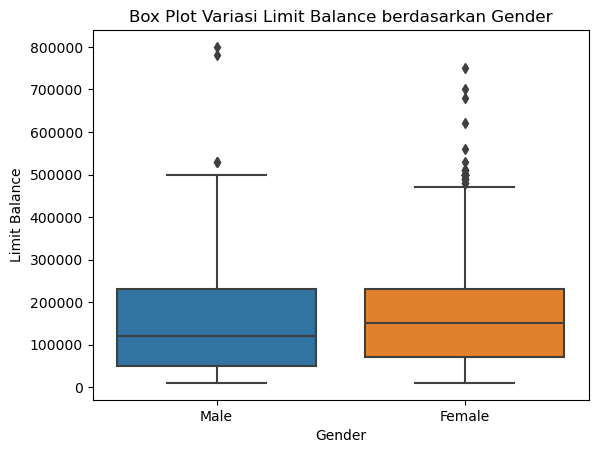

In [17]:
# make a box plot
sns.boxplot(x='new_sex',y='limit_balance',data=variasi_harga)

# memberikan label
plt.xlabel('Gender')
plt.ylabel('Limit Balance')
plt.title('Box Plot Variasi Limit Balance berdasarkan Gender')

# Displaying the plot
plt.show()

In [18]:
# ANOVA TEST
res = stats.f_oneway(variasi_harga['sex'], variasi_harga['limit_balance'])
print('P-value:',res.pvalue)

P-value: 0.0


### **INSIGHT:**

- Hasil statistika deskriptif pada limit_balance setiap gender menunjukkan bahwa Female memiliki rata-rata limit_balance daripada Male (166237 > 158926). Namun, variance limit_balance Male serta limit_balance tertinggi lebih tinggi daripada Female (800000 > 750000).

- Melalui boxplot, terlihat lebih jelas bahwa limit_balance tiap gender memiliki rata-rata serta nilai kuartil yang mirip. Akan tetapi, jumlah outlier limit_balance pada kategori Female lebih banyak daripada Male.

- Hasil ANOVA test menyatakan bahwa jumlah limit_balance berbeda berdasarkan gender karena p-value = 0.

### **Check Linear Relationship between Features and Target**
- Purpose: To see if PCA can be used in feature engineering.
- Method: Correlation matrix.

In [21]:
# create correlation matrix
correlation_matrix_data = main_data.corr()

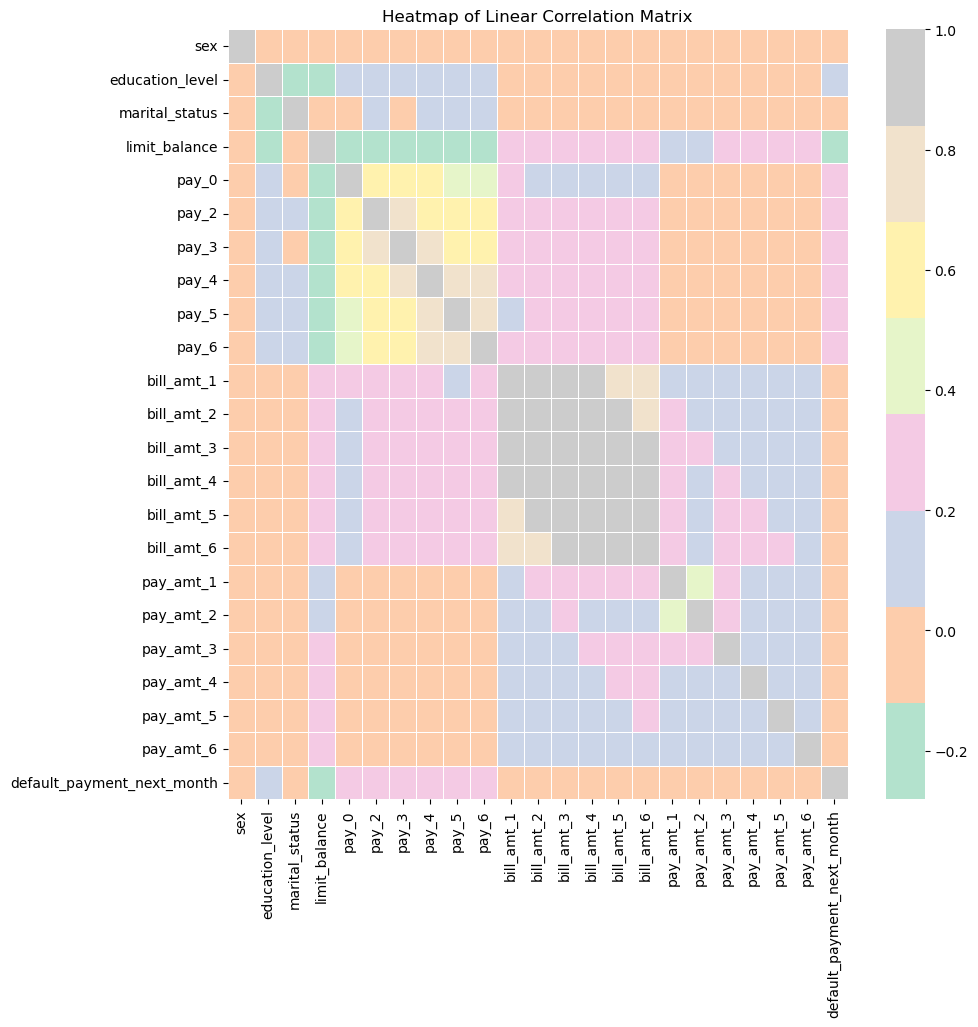

In [23]:
# create heatmap showing the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix_data,annot=False,cmap='Pastel2',fmt=".2f",linewidth=0.5)
plt.title('Heatmap of Linear Correlation Matrix')
plt.show()

### **INSIGHT:**

- As all columns are either having weak linear relationship (pink, blue, or light green) with the target variable (default_payment_next_month) or no relationship (orange), it is concluded that PCA can be used.
- The features about amount of bill statement from the bank are highly linearly correlated with one another (coefficient is near to 1; grey color).

# **6. FEATURE ENGINEERING**

## i. **Feature Creation**
- Spliting dataset.

In [5]:
# Define X and y values
X = main_data.drop('default_payment_next_month',axis = 1)
y = main_data['default_payment_next_month']

In [6]:
# Splitting datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [7]:
# Check how many data is classified as default (1) and non-default (0)
print('Before undersampling: ', Counter(y_train))

Before undersampling:  Counter({0: 1852, 1: 520})


## ii. **Data Balancing**
`Objective`: to reduce bias on the major class when doing classification tasks.

`Method`: undersampling, SMOTE-NC

### a. Undersampling the major class (default = 0)

In [8]:
# undersampling process
# combine the features and target variable into a dataframe
train_df = pd.concat([X_train,y_train], axis = 1)

# separate the majority and minority classes in the dataset
majority_data = train_df[train_df['default_payment_next_month']==0]
minority_data = train_df[train_df['default_payment_next_month']==1]

# decide how many data to keep in the majority class
n_samples = len(minority_data)

# perform undersampling
downsampling_majority = resample(majority_data,
                                 replace = False,
                                 n_samples = n_samples,
                                 random_state = 21)

# combine the majority data with minority data
undersampling_result = pd.concat([downsampling_majority,minority_data])

# redefine the train set
X_train_resampled = undersampling_result.drop('default_payment_next_month', axis = 1)
y_train_resampled = undersampling_result['default_payment_next_month']

In [9]:
# see if the data is already balanced or not
print('After undersampling:', Counter(y_train_resampled))

After undersampling: Counter({0: 520, 1: 520})


### b. Oversampling Minor Class (default = 1) with SMOTE-NC

In [10]:
# data balancing
categorical_features_indices =[0,1,2,3,4,5,6,7,8,9,10,16,17,18,19,20,21]

# Initialize SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)

# Apply SMOTENC to the training data only
X_train_resampled_2, y_train_resampled_2 = smote_nc.fit_resample(X_train, y_train)

In [13]:
# see if the data is already balanced or not
print('After oversampling:', Counter(y_train_resampled_2))

After oversampling: Counter({0: 1852, 1: 1852})


### c. Use Original Data

In [11]:
# show the original train set
X_train

,sex,education_level,marital_status,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
118,1,1,2,300000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31180.0,19507.0,18169.0,18533.0,4103.0,1427.0,600.0,1200.0,2500.0,18000.0
794,2,2,1,160000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7035.0,4596.0,4635.0,2744.0,2000.0,1000.0,500.0,1000.0,1000.0,2000.0
1493,2,3,1,130000.0,-1.0,2.0,2.0,-1.0,0.0,-1.0,...,0.0,632.0,316.0,316.0,0.0,0.0,948.0,0.0,316.0,316.0
647,2,2,1,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22844.0,22101.0,19535.0,19580.0,1712.0,1400.0,442.0,391.0,500.0,0.0
2469,1,1,2,500000.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,...,0.0,3887.0,0.0,7413.0,22650.0,0.0,3887.0,0.0,7413.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2,2,2,340000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,4794.0,7819.0,332.0,16516.0,9318.0,5343.0,7819.0,332.0,16516.0,5000.0
48,1,1,2,310000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,283847.0,290135.0,293350.0,300623.0,10010.0,11500.0,11015.0,11000.0,12000.0,23035.0
772,2,2,2,120000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9624.0,20129.0,10388.0,13316.0,1137.0,1514.0,1069.0,278.0,3000.0,0.0
1848,2,2,1,60000.0,0.0,0.0,2.0,2.0,2.0,2.0,...,39676.0,42407.0,41428.0,45576.0,4000.0,0.0,3700.0,0.0,5000.0,2000.0


## ii. **Feature Extraction, Transformation, dan Selection**
- Feature scaling and PCA for dimensionality reduction.
- PCA is chosen since the features are still linearly related with the target variable and it's computationally lighter than UMAP and t-SNE.

### a. Undersampled Train Set

In [12]:
# Feature scaling with StandardScaler and PCA
scaler_undersample = StandardScaler()
X_train_resampled_scaled = scaler_undersample.fit_transform(X_train_resampled)
pca_undersample = PCA()
pca_undersample.fit(X_train_resampled_scaled)

PCA()

Text(0, 0.5, 'Nilai Kumulatif Explained Variance Ratio')

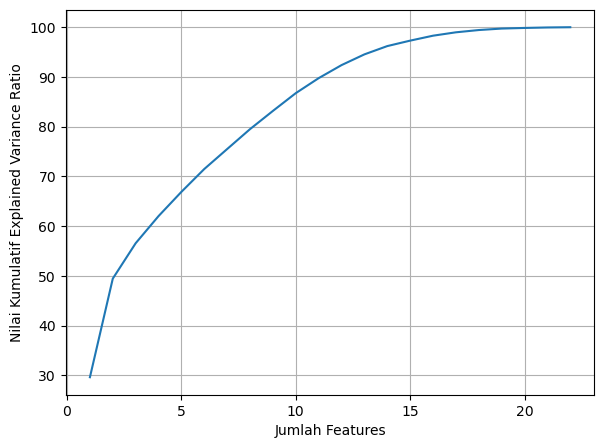

In [13]:
# Membuat plot untuk Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 23), np.cumsum(pca_undersample.explained_variance_ratio_ * 100))
plt.xlabel('Jumlah Features')
plt.ylabel('Nilai Kumulatif Explained Variance Ratio')

Text(0, 0.5, 'Eigenvalues')

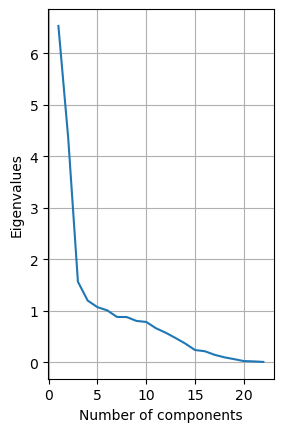

In [15]:
# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 23), pca_undersample.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [55]:
# Check jumlah feature yang akan digunakan bila ingin menyimpan 90 % dari total informasi
cum_sum = np.cumsum(pca_undersample.explained_variance_ratio_)
jumlah_features = np.argmax(cum_sum >= 0.95) + 1
print("Jumlah features yang akan digunakan jika mempertimbangkan cumulative explained variance ratio: ",jumlah_features)

Jumlah features yang akan digunakan jika mempertimbangkan cumulative explained variance ratio:  14


In [56]:
# Lakukan PCA model training dengan jumlah komponen yang baru yaitu 14
pca_undersampled = PCA(n_components=14)
pca_undersampled.fit(X_train_resampled_scaled)

# transform
X_train_undersampled_pca = pca_undersampled.transform(X_train_resampled_scaled)

In [57]:
# transform the test set
X_test_resampled_scaled = scaler_undersample.transform(X_test)
X_test_undersampled_pca = pca_undersampled.transform(X_test_resampled_scaled)

### b. Oversampled Train Set

In [19]:
# Feature scaling with StandardScaler and PCA
scaler_oversample = StandardScaler()
X_train_oversample_scaled = scaler_oversample.fit_transform(X_train_resampled_2)
pca_oversample = PCA()
pca_oversample.fit(X_train_oversample_scaled)

PCA()

Text(0, 0.5, 'Nilai Kumulatif Explained Variance Ratio')

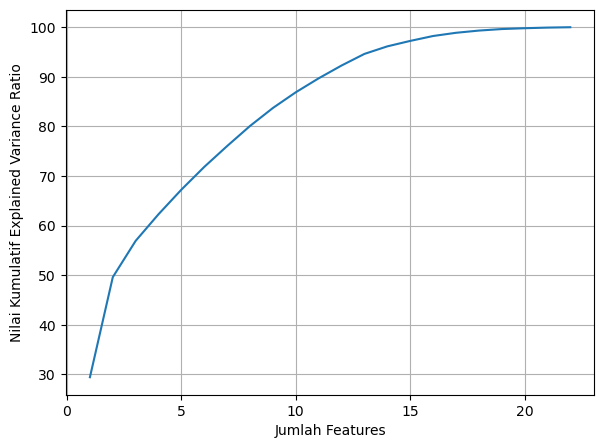

In [20]:
# Membuat plot untuk Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 23), np.cumsum(pca_oversample.explained_variance_ratio_ * 100))
plt.xlabel('Jumlah Features')
plt.ylabel('Nilai Kumulatif Explained Variance Ratio')

Text(0, 0.5, 'Eigenvalues')

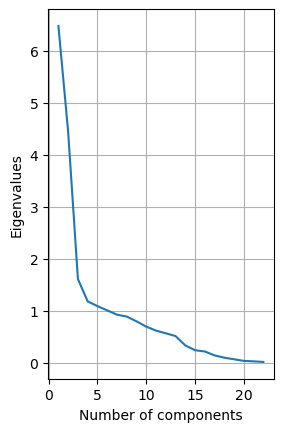

In [21]:
# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 23), pca_oversample.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [58]:
# Check jumlah feature yang akan digunakan bila ingin menyimpan 90 % dari total informasi
cum_sum_2 = np.cumsum(pca_oversample.explained_variance_ratio_)
jumlah_features = np.argmax(cum_sum_2 >= 0.95) + 1
print("Jumlah features yang akan digunakan jika mempertimbangkan cumulative explained variance ratio: ",jumlah_features)

Jumlah features yang akan digunakan jika mempertimbangkan cumulative explained variance ratio:  14


In [59]:
# Lakukan PCA model training dengan jumlah komponen yang baru yaitu 14
pca_oversampled = PCA(n_components=14)
pca_oversampled.fit(X_train_oversample_scaled)

# transform
X_train_oversampled_pca = pca_undersampled.transform(X_train_oversample_scaled)

In [60]:
# transform the test set
X_test_oversampled_scaled = scaler_oversample.transform(X_test)
X_test_oversampled_pca = pca_oversampled.transform(X_test_oversampled_scaled)

### c. Original Train Set

In [92]:
# Feature scaling with StandardScaler and PCA
scaler_fx = StandardScaler()
X_train_scaled = scaler_fx.fit_transform(X_train)
pca = PCA()
pca.fit(X_train_scaled)

PCA()

Text(0, 0.5, 'Nilai Kumulatif Explained Variance Ratio')

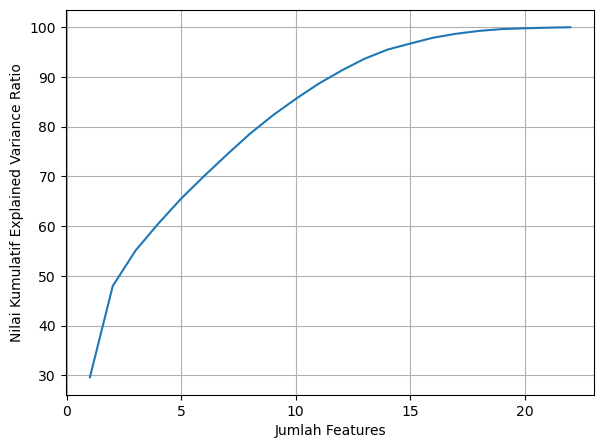

In [26]:
# Membuat plot untuk Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 23), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Jumlah Features')
plt.ylabel('Nilai Kumulatif Explained Variance Ratio')

In [74]:
# Check jumlah feature yang akan digunakan bila ingin menyimpan 90 % dari total informasi
cum_sum_3 = np.cumsum(pca.explained_variance_ratio_)
jumlah_features = np.argmax(cum_sum_3 >= 0.99) + 1
print("Jumlah features yang akan digunakan jika mempertimbangkan cumulative explained variance ratio: ",jumlah_features)

Jumlah features yang akan digunakan jika mempertimbangkan cumulative explained variance ratio:  18


In [91]:
# Lakukan PCA model training dengan jumlah komponen yang baru yaitu 18
scaler_fx = StandardScaler()
pca_ori = PCA(n_components=18)
pca_ori.fit(X_train_scaled)

# transform
X_train_ori_pca = pca_ori.transform(X_train_scaled)

In [89]:
# transform the test set
X_test_ori_scaled = scaler_oversample.transform(X_test)
X_test_ori_pca = pca_oversampled.transform(X_test_ori_scaled)

In [90]:
X_test_ori_pca.shape

(593, 14)

# **7. MODEL DEFINITION**

Based on paper by Nicolas Suhadolnik, et al. in 2023, the most common credit risk classification methods are neural networks, support vector machines, fuzzy logic, logistic regression, decision trees, and ensemble methods. 

Meanwhile, Katie Shewell from Medium mentioned that logistic regression is widely used in the credit risk industry due to its simplicity.

Apart from that, based on the previous modeling file, logistic regression showed the best performance.

So, logistic regression with the same hyperparameter tuning setup will be used for this study. The performance of the model will be compared based on data balancing methods (undersampling, oversampling, and original).



# **8. MODEL TRAINING**

### <u>Logistic Regression Model</u>

#### Without Pipeline

In [30]:
# # memanggil ML algorithm
# model_logreg = LogisticRegression(penalty='l2', C=1.0, random_state=0)
# model_logreg.fit(X_train_scaled, y_train_resampled)

# print('Coefficient : ', model_logreg.coef_)
# print('Intercept   : ', model_logreg.intercept_)

ValueError: Found input variables with inconsistent numbers of samples: [2372, 1040]

#### With Pipeline

In [64]:
# define pipeline
pipe_log = Pipeline([('logreg', LogisticRegression(random_state=42))])

### a. Undersampled Trained Data

In [65]:
# Hyperparameter tuning
grid_search_params = {
    'logreg__C': [0.1,0.5, 1,10],
    'logreg__multi_class':['ovr'],    # Hyperparameter untuk pilihan output binary
    'logreg__class_weight':[{0:1,1:5},{0:1.5,1:3},{0:1.5,1:2.5},{0:1.75,1:2.5}],
    'logreg__max_iter' : [100,150,200]
}

clf_undersampled = GridSearchCV(pipe_log, param_grid=grid_search_params, cv=5)
clf_undersampled.fit(X_train_undersampled_pca, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logreg__C': [0.1, 0.5, 1, 10],
                         'logreg__class_weight': [{0: 1, 1: 5}, {0: 1.5, 1: 3},
                                                  {0: 1.5, 1: 2.5},
                                                  {0: 1.75, 1: 2.5}],
                         'logreg__max_iter': [100, 150, 200],
                         'logreg__multi_class': ['ovr']})

### b. Oversampled Trained Data

In [66]:
# Hyperparameter tuning
grid_search_params_2 = {
    'logreg__C': [0.1,0.5, 1,10],
    'logreg__multi_class':['ovr'],    # Hyperparameter untuk pilihan output binary
    'logreg__class_weight':[{0:1,1:5},{0:1.5,1:3},{0:1.5,1:2.5},{0:1.75,1:2.5}],
    'logreg__max_iter' : [100,150,200]
}

clf_oversampled = GridSearchCV(pipe_log, param_grid=grid_search_params_2, cv=5)
clf_oversampled.fit(X_train_oversampled_pca, y_train_resampled_2)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logreg__C': [0.1, 0.5, 1, 10],
                         'logreg__class_weight': [{0: 1, 1: 5}, {0: 1.5, 1: 3},
                                                  {0: 1.5, 1: 2.5},
                                                  {0: 1.75, 1: 2.5}],
                         'logreg__max_iter': [100, 150, 200],
                         'logreg__multi_class': ['ovr']})

### c. Original Trained Data

In [86]:
# Hyperparameter tuning
grid_search_params_3 = {
    'logreg__C': [0.1,0.5, 1,10],
    'logreg__multi_class':['ovr'],    # Hyperparameter untuk pilihan output binary
    'logreg__class_weight':[{0:1,1:5},{0:1.5,1:3},{0:1.5,1:2.5},{0:1.75,1:2.5}],
    'logreg__max_iter' : [100,150,200]
}

clf_ori = GridSearchCV(pipe_log, param_grid=grid_search_params_3, cv=5)
clf_ori.fit(X_train_ori_pca, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logreg__C': [0.1, 0.5, 1, 10],
                         'logreg__class_weight': [{0: 1, 1: 5}, {0: 1.5, 1: 3},
                                                  {0: 1.5, 1: 2.5},
                                                  {0: 1.75, 1: 2.5}],
                         'logreg__max_iter': [100, 150, 200],
                         'logreg__multi_class': ['ovr']})

### <u>Support Vector Machine</u>

#### Without Pipeline

In [43]:
# memanggil ML algorithm
scaled_svm = SVC(kernel='linear')

# melakukan fitting
scaled_svm.fit(X_train_scaled, y_train)

SVC(kernel='linear')

#### With Pipeline

In [102]:
# define pipeline
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('umap',umap.UMAP()),
                     ('svm',SVC())])

In [96]:
# Hyperparameter tuning
random_search_params2 = {
    'umap__n_neighbors': [2,8],
    'umap__min_dist': [0.15],
    'umap__n_components':[15],
    'svm__C': [0.01, 1],     # Hyperparameters for SVC
    'svm__gamma': [0.01, 1],
    'svm__kernel': ['rbf'],
    'svm__class_weight': [{0:1.5}]
}

clf_random2 = RandomizedSearchCV(pipe_svm, param_distributions=random_search_params2,random_state = 21, cv=5)
clf_random2.fit(X_train, y_train)

/Users/catherinemulyadi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('umap', UMAP()),
                                             ('svm', SVC())]),
                   param_distributions={'svm__C': [0.01, 1],
                                        'svm__class_weight': [{0: 1.5}],
                                        'svm__gamma': [0.01, 1],
                                        'svm__kernel': ['rbf'],
                                        'umap__min_dist': [0.15],
                                        'umap__n_components': [15],
                                        'umap__n_neighbors': [2, 8]},
                   random_state=21)

In [116]:
# Hyperparameter tuning
grid_search_params2 = {
    'umap__n_neighbors': [8,10],
    'umap__min_dist': [0.15],
    'umap__n_components':[15],
    'svm__C': [0.01, 1],     # Hyperparameters for SVC
    'svm__gamma': [0.01, 1],
    'svm__kernel': ['rbf'],
    'svm__class_weight': [{0:1.5}]
}

clf_grid2 = GridSearchCV(pipe_svm, param_grid=grid_search_params2, cv=5)
clf_grid2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('umap', UMAP()), ('svm', SVC())]),
             param_grid={'svm__C': [0.01, 1], 'svm__class_weight': [{0: 1.5}],
                         'svm__gamma': [0.01, 1], 'svm__kernel': ['rbf'],
                         'umap__min_dist': [0.15], 'umap__n_components': [15],
                         'umap__n_neighbors': [8, 10]})

### <u>K-Nearest Neighbours</u>

#### Without Pipeline

In [46]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

#### With Pipeline

In [22]:
# define pipeline
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('umap',umap.UMAP()),
                     ('KNN',KNeighborsClassifier())])

In [23]:
# Hyperparameter tuning
random_search_params3 = {
    'umap__n_neighbors': [2,8,10],
    'umap__min_dist': [0.25,0.5],
    'umap__n_components': [20,30],
    'KNN__n_neighbors': [2,6,8],
    'KNN__weights': ['uniform', 'distance'],  # Contoh opsi weight
    'KNN__metric': ['euclidean', 'manhattan','minkowski'], # metrik untuk distance
    'KNN__p': [1,2]
}

# call pipeline for modelling
clf_random3 = RandomizedSearchCV(pipe_knn, param_distributions=random_search_params3, cv=5,random_state = 21)
clf_random3.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('umap', UMAP()),
                                             ('KNN', KNeighborsClassifier())]),
                   param_distributions={'KNN__metric': ['euclidean',
                                                        'manhattan',
                                                        'minkowski'],
                                        'KNN__n_neighbors': [2, 6, 8],
                                        'KNN__p': [1, 2],
                                        'KNN__weights': ['uniform', 'distance'],
                                        'umap__min_dist': [0.25, 0.5],
                                        'umap__n_components': [20, 30],
                                        'umap__n_neighbors': [2, 8, 10]},
                   random_state=21)

# **9. MODEL EVALUATION**

- Menggunakan metrics evaluasi: f1 - score karena ingin mengevaluasi robustness model dalam menangani setiap kasus pada variabel target (kena atau tidak kena default).

## Fungsi yang digunakan:

In [36]:
# find best hyperparameter and estimator
def best_hyper_estimator(clf_grid):
  
  best_params = clf_grid.best_params_
  best_estimator = clf_grid.best_estimator_

  print("Best hyperparameter: ", best_params)
  print("Best estimator: ", best_estimator)

In [47]:
# fungsi untuk pengukuran f1 - score
def performance_checker(clf, X_train, y_train,X_test, y_test):
  
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
    
  print("Train Set:")
  cm_train = confusion_matrix(y_train, y_pred_train)
  ConfusionMatrixDisplay(cm_train).plot()
  print(classification_report(y_train, y_pred_train))

  print("Test Set:")
  cm_test = confusion_matrix(y_test, y_pred_test)
  ConfusionMatrixDisplay(cm_test).plot()
  print(classification_report(y_test, y_pred_test))

## With Pipeline and Hyperparameter Tuning

### a. Undersampled Trained Data: Test Result

In [46]:
# show the best hyperparameter and estimator setting
best_hyper_estimator(clf_undersampled)

Best hyperparameter:  {'logreg__C': 0.1, 'logreg__class_weight': {0: 1.75, 1: 2.5}, 'logreg__max_iter': 100, 'logreg__multi_class': 'ovr'}
Best estimator:  Pipeline(steps=[('logreg',
                 LogisticRegression(C=0.1, class_weight={0: 1.75, 1: 2.5},
                                    multi_class='ovr', random_state=42))])


In [68]:
# Get the interdcept and coefficient from the best estimator model from Logistic Regression
best_undersampled_log = clf_undersampled.best_estimator_
print('Coefficient : ', best_undersampled_log.named_steps['logreg'].coef_)
print('Intercept   : ', best_undersampled_log.named_steps['logreg'].intercept_)

Coefficient :  [[ 0.06592619 -0.48404554 -0.34594303  0.07871528 -0.00327295 -0.04578311
   0.2266149   0.10705186  0.08876052  0.08155165  0.03042295 -0.22546983
  -0.29868657 -0.3705203 ]]
Intercept   :  [0.33397853]


Train Set:
              precision    recall  f1-score   support

           0       0.68      0.46      0.55       520
           1       0.59      0.79      0.68       520

    accuracy                           0.62      1040
   macro avg       0.64      0.62      0.61      1040
weighted avg       0.64      0.62      0.61      1040

Test Set:
              precision    recall  f1-score   support

           0       0.93      0.46      0.61       478
           1       0.27      0.85      0.41       115

    accuracy                           0.53       593
   macro avg       0.60      0.65      0.51       593
weighted avg       0.80      0.53      0.57       593



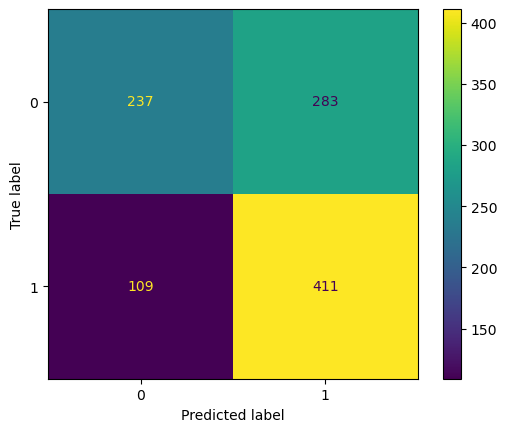

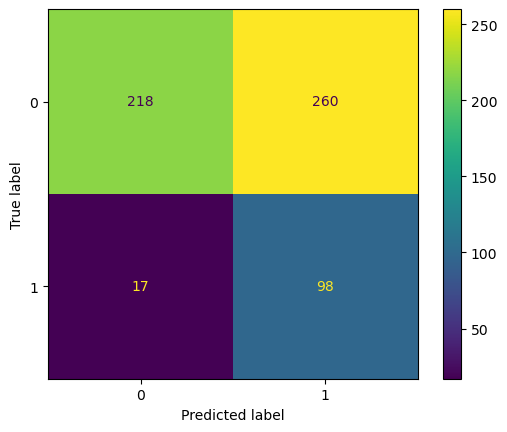

In [69]:
# Hasil best estimator untuk Logistic Regression 
performance_checker(best_undersampled_log, X_train_undersampled_pca, y_train_resampled,X_test_undersampled_pca, y_test)

### b. Oversampled Trained Data: Test Result

In [70]:
# Get the interdcept and coefficient from the best estimator model from Logistic Regression
best_oversampled_log = clf_oversampled.best_estimator_
print('Coefficient : ', best_oversampled_log.named_steps['logreg'].coef_)
print('Intercept   : ', best_oversampled_log.named_steps['logreg'].intercept_)

Coefficient :  [[ 0.00528112 -0.63778442 -1.04753105  0.00230327 -0.04831096 -0.1997295
   0.21758291  0.03140472  0.22633118  0.32426173 -0.37916028 -0.04989003
   0.00510409 -0.42966785]]
Intercept   :  [0.19950343]


Train Set:
              precision    recall  f1-score   support

           0       0.73      0.47      0.57      1852
           1       0.61      0.83      0.70      1852

    accuracy                           0.65      3704
   macro avg       0.67      0.65      0.64      3704
weighted avg       0.67      0.65      0.64      3704

Test Set:
              precision    recall  f1-score   support

           0       0.91      0.47      0.62       478
           1       0.27      0.81      0.40       115

    accuracy                           0.54       593
   macro avg       0.59      0.64      0.51       593
weighted avg       0.79      0.54      0.58       593



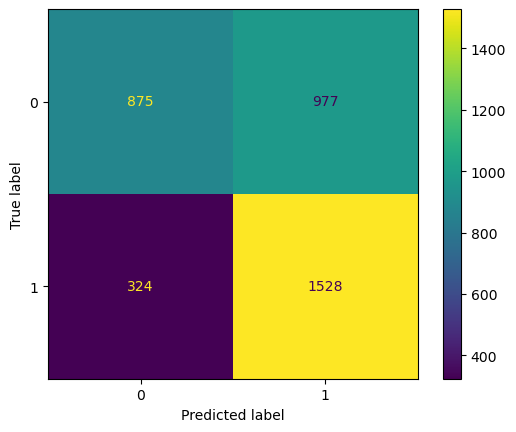

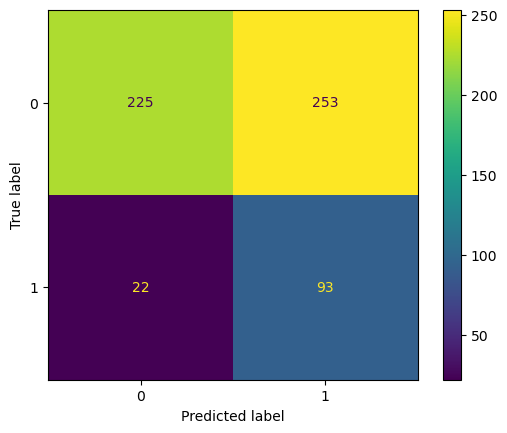

In [71]:
# Hasil best estimator untuk Logistic Regression 
performance_checker(best_oversampled_log, X_train_oversampled_pca, y_train_resampled_2,X_test_oversampled_pca, y_test)

### c. Original Trained Data: Test Result

In [87]:
# Get the interdcept and coefficient from the best estimator model from Logistic Regression
best_ori_log = clf_ori.best_estimator_
print('Coefficient : ', best_ori_log.named_steps['logreg'].coef_)
print('Intercept   : ', best_ori_log.named_steps['logreg'].intercept_)

Coefficient :  [[ 9.46660845e-02 -5.13784992e-01 -4.59059056e-01  2.74931470e-02
  -6.14801666e-02 -1.16049340e-01 -3.88899013e-02  1.40189508e-01
  -7.02186921e-02 -1.43918260e-01  2.09535929e-01  2.97359910e-01
  -2.96363912e-01  3.83812604e-01  1.05964891e-04  2.03036892e-01
  -5.86976481e-02  2.40447324e-01]]
Intercept   :  [-1.04991054]


In [88]:
# Hasil best estimator untuk Logistic Regression 
performance_checker(best_ori_log, X_train_ori_pca, y_train,X_test_ori_pca, y_test)

ValueError: X has 14 features, but LogisticRegression is expecting 18 features as input.

### **INSIGHT:**
- Untuk setiap model (Logistic Regression, SVM, KNN), dibuat model baseline tanpa pipeline (seadanya, mengikuti default, dan hyperparameter simple) dan model dengan pipeline (hyperparameter diset dan dicari yang paling optimal). 

- Tujuan dari pemisahan model tanpa pipeline dan berpipeline adalah untuk membandingkan robustness model melalui peningkatan f1 - score pada setiap jenis model apabila pipeline digunakan.

- Hasil akan dibandingkan berdasarkan tipe model:
    - Logistic Regression
        - Bila pipeline tidak digunakan, model kurang konsisten dalam menangani kasus penentuan default pada nasabah (default_payment_next_month = 1) karena n f1 - score dari training set lebih tinggi daripada test set (43% turun menjadi 11%).
        
        - Sedangkan, setelah pipeline dengan hyperparameter tuning dilakukan, model menjadi lebih konsisten dalam menangani kasus penentuan default pada nasabah (default_payment_next_month = 1) karena n f1 - score dari training set kurang lebih sama dengan test set (52% naik menjadi 54%) dengan performa moderat (f1 - score >= 50%).
    - SVM
        - Jika pipeline tidak digunakan, model memiliki kemampuan moderat cenderung kurang baik dalam menangani kasus baik penentuan default pada nasabah (default_payment_next_month = 1) maupun tidak kena default (default_payment_next_month = 0). Nilai f1 - score dari training set dan test set sama-sama berkisar di 50% untuk kasus non-default. Sedangkan, f1 - score dari training set dan test set pada kasus kena default adalah 30%.

        - Setelah pipeline dengan hyperparameter tuning dilakukan, model mengalami peningkatan performa dan konsistensi dalam menangani kasus penentuan default pada nasabah (default_payment_next_month = 1) serta kasus non-default. Hal ini tercermin melalui nilai f1 - score untuk kasus kena default dari training set kurang lebih sama dengan test set (59% turun menjadi 53%). Lalu, penanganan kasus tidak kena default baik karena f1 - score mendekati 1 baik untuk training set sama dengan test set (sama-sama 91%).

    - KNN
        -Kalau pipeline tidak digunakan, model memiliki kemampuan kurang baik dalam penentuan default pada nasabah (default_payment_next_month = 1), tetapi baik untuk kasus tidak kena default (default_payment_next_month = 0). Nilai f1 - score untuk kasus tidak kena default dari training set dan test set mendekati 1. Namun, f1 - score untuk kasus kena default dari training set mengalami penurunan saat diuji di test set (69% menjadi 39%).

        - Selanjutnya, penggunaan pipeline dengan hyperparameter tuning hanya memberi sedikit peningkatan pada f1 - score untuk kasus kena default dari segi kedekatan nilai train set dan test set (44% dan 34%). Tetapi, performa model secara garis besar tetap serupa dan kurang baik.

- Salah satu model SVM yang memiliki hyperparameter: 'svm__C': 10, 'svm__class_weight': {0: 1.5, 1: 2.5}, 'svm__gamma': 0.01, 'svm__kernel': 'rbf' dipiih sebagai model terbaik dalam studi ini karena memiliki f1 - score tertinggi baik untuk penanganan kasus tidak kena maupun kena default.

In [ ]:
# # get the relevant variables
# y_true = y_test

# # extract the probability of class 1
# y_pred_proba_log = best_undersampled_log.predict_proba(X_test)[:,1]
# y_pred_proba_log2 = best_oversampled_log.predict_proba(X_test)[:,1]
# y_pred_proba_log3 = best_ori_log.predict_proba(X_test)[:,1]


# # Calculate the ROC curve
# fpr_log,tpr_log, thresholds_log = roc_curve(y_true, y_pred_proba_log)
# fpr_log2,tpr_log2, thresholds_log = roc_curve(y_true, y_pred_proba_log2)
# fpr_log3,tpr_log3, thresholds_knn = roc_curve(y_true, y_pred_proba_log3)


# # Find the ROC-AUC score
# roc_auc_val_log = roc_auc_score(y_true, y_pred_proba_log)
# roc_auc_val_svm = roc_auc_score(y_true, y_pred_proba_svm)
# # roc_auc_val_knn = roc_auc_score(y_true, y_pred_proba_knn)



# # Make the plot
# plt.figure(figsize=(8,8))
# plt.plot(fpr_log,tpr_log, color = 'lightblue', lw=2, label =f'ROC Curve (AUC of Logistic Regression = {roc_auc_val_log:.2f})')
# plt.plot(fpr_svm,tpr_svm, color = 'pink', lw=2, label =f'ROC Curve (AUC of SVC = {roc_auc_val_svm:.2f})')
# plt.plot(fpr_knn,tpr_knn, color = 'lightgrey', lw=2, label =f'ROC Curve (AUC of KNN = {roc_auc_val_knn:.2f})')


# plt.plot([0,1],[0,1],color = 'gray',linestyle='--')
# plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.legend(loc='lower right')
# plt.show()

# **10. MODEL SAVING**

In [43]:
# # Menyimpan file berkaitan dengan model terbaik serta metode scaling

# # with open('model.pkl', 'wb') as file_1:
#   pickle.dump(best_estimator_svm, file_1)

# with open('model_scaler.pkl', 'wb') as file_2:
#   pickle.dump(scaler_fx, file_2)

# **11. MODEL INFERENCE**

- Menyiapkan data baru untuk tes performa model.

### Proses Persiapan Inference Data Sampai Pemodelan

In [50]:
# create new dataset
inference_data = {'sex': [1,0],'education_level':[3,4],'marital_status':[2,1],'limit_balance':[8500,9000],'pay_0':[-1,2],'pay_2':[2,2],'pay_3':[-1,-1],'pay_4':[-1,3],'pay_5':[3,-1],'pay_6':[-1,2],'bill_amt_1':[1200,250],'bill_amt_2':[150,300],'bill_amt_3':[1000,1200],'bill_amt_4':[240,125],'bill_amt_5':[150,200],'bill_amt_6':[50,80], 'pay_amt_1':[100,200],'pay_amt_2':[200,200],'pay_amt_3':[100,800],'pay_amt_4':[200,125],'pay_amt_5':[0,100],'pay_amt_6':[240,60],'default_payment_next_month':[0,1]}

inference_df = pd.DataFrame(inference_data)

inference_df

,sex,education_level,marital_status,limit_balance,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,1,3,2,8500,-1,2,-1,-1,3,-1,...,240,150,50,100,200,100,200,0,240,0
1,0,4,1,9000,2,2,-1,3,-1,2,...,125,200,80,200,200,800,125,100,60,1


In [51]:
# define X and y
X_inf = inference_df.drop('default_payment_next_month',axis = 1)
y_inf = inference_df['default_payment_next_month']

In [52]:
# scaled using standardscaler()
X_inf_scaled =scaler_fx.transform(X_inf)

In [53]:
# Bandingkan hasil prediksi dari inference data dengan hasil test 
performance_checker(best_estimator_svm, X_inf, y_inf,X_test, y_test)

Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Test Set:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       478
           1       0.63      0.46      0.53       115

    accuracy                           0.84       593
   macro avg       0.75      0.70      0.72       593
weighted avg       0.83      0.84      0.83       593



### **INSIGHT:**
- Bila model dihadapkan dengan dataset yang balanced, maka kemampuan model untuk memutuskan apakah nasabah kena default atau tidak menjadi sempurna karena nilai f1 - score untuk tidak kena default (0) dan kena default (1) hasilnya adalah 1.

- Bisa dilihat, bila dibanding dengan test set, model inference menunjukkan konsistensi dalam memprediksi keputusan kena default atau tidak dengan performa lebih baik. Hal ini karena test set memiliki jumlah data dengan kasus tidak kena default (0) lebih banyak daripada yang kena default (1) sehingga prediksi model pada kasus default (1) tidak sebaik dengan kasus non-default (0).

# **12. CONCLUSION**
- Kesimpulan EDA, Evaluasi Model, Analysis Model, Ide Peningkatan Model

## <u>Menjawab Conceptual Problems</u>

1. Apakah yang dimaksud dengan coefficient pada logistic regression?
    - coefficient pada logistic regression melambangkan hubungan antara feature dengan kemungkinan suatu event dari variabel dependen. Logistic regression menggunakan fungsi logit untuk memetakan kemungkinan kejadian yang terjadi pada nilai bilangan nyata (real) sehingga analisis regresi dapat dilakukan.

2. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!
    - Kernel adalah sebuah fungsi untuk meningkatkan dimensi feature data ke tingkat yang lebih tinggi dengan membuat decision boundaries. Tujuan dari pengubahan ini adalah untuk membuat pemisahan linear dan klasifikasi dataset lebih mudah.
    - Salah satu jenis kernel yang tersedia pada SVM adalah RBF. RBF adalah jenis kernel yang paling versatile karena RBF tidak memerlukan pengetahuan mengenai distribusi data sehingga class non-linear dapat dipisahkan dengan baik meskipun data memiliki variasi tinggi dan outlier. Namun, kernel ini membuat model menjadi complex sehingga memakan waktu lebih lama dibanding kernel lainnya.

3. Bagaimana cara memilih K yang optimal pada KNN ?
    - Pemilihan nilai K yang optimal pada KKN dapat dilakukan dengan menggunakan metode GridSearchCV (cross validation search) di mana data dibagi dalam k-folds dan dilatih sebanyak k kali. Kemudian, performa model dapat diukur dengan metrik klasifikasi seperti accuracy, f1 - score.

4. Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?
    - Accuracy => metrik untuk mengukur seberapa akurat prediksi model kita dari skala 1 sampai 100%. Akurasi diukur dari rasio antara jumlah prediksi yang tepat / jumlah data. Metrik ini hanya bisa dipakai bila class datanya seimbang.
    - Precision/Positive Predictive Value => metrik untuk mengukur seberapa benar hasil prediksi untuk kelas positif. Precision diukur dari rasio antara jumlah data positive yang benar dan jumlah data yang dinyatakan positif oleh model. Cocok ketika ingin nmenurunkan jumlah data False Positive.
    - Recall/ Sensitivity/ True Positive Rate (TPR) => metrik untuk mengukur seberapa sering model mendeteksi nilai positif yang benar dari seluruh jumlah data positif sebenarnya yang ada di model. Cocok untuk menurunkan jumlah data False Negative.
    - F1 score => penggabungan konsep precision dan recall yang berarti mempertimbangkan pentingnya jumlah data False Positive dan False Negative. Cocok bila ingin menurunkan jumlah False detection serta untuk class yang balanced maupun imbalanced; lebih robust daripada accuracy.

## <u>EDA</u>

Insights dari bar graph mengenai jumlah karyawan berdasarkan gender:
- Hasil bar graph menunjukkan bahwa jumlah nasabah wanita (Female) lebih banyak daripada pria (Male). Perbedaan jumlah nasabah wanita dan pria adalah 1802-1163 = 639 nasabah.

Insights dari boxplot, descriptive statistics, dan ANOVA test dalam mempelajari hubungan antara gender dan limit_balance:

- Hasil  statistika deskriptif dan boxplot, terlihat lebih jelas bahwa limit_balance tiap gender memiliki rata-rata, nilai kuartil, dan distribusi data non-outlier yang serupa (dari 10000 - 500000). Akan tetapi, jumlah outlier limit_balance pada kategori Female lebih banyak daripada Male.

- Hasil ANOVA test menyatakan bahwa jumlah limit_balance berbeda berdasarkan gender karena p-value = 0.

## <u>Model Evaluation and Analysis</u>

- Berdasarkan hasil analysis pada bagian model evaluation, disimpulkan bahwa pipeline dapat membantu meningkatkan performa model. Penggunaan pipeline membantu penyediaan hyperparameter tuning yang beragam pada setiap model, kemudian model dengan hyperparameter terbaik dapat dipilih untuk fitting.

- Secara umum, semua model (kecuali SVM tanpa hyperparameter tuning) mampu memprediksi kasus nasabah tidak kena default dengan baik karena nilai f1 - score mendekati 1 baik untuk train set maupun test set. Namun, model-model tanpa hyperparameter tuning yang disimpan dalam pipeline memiliki masalah prediksi kasus nasabah kena default karena f1 - score train set lebih tinggi daripada f1 - score test set dan nilainya di bawah 50% (kurang dari moderat).

- Tapi, model-model yang mengalami peningkatan signifikan berdasarkan nilai f1 - score untuk kasus prediksi nasabah kena default dengan hyperparameter tuning adalah SVM (paling baik) dan Logistic Regression. Meskipun f1 - score kedua model ini bersifat moderat (sekita 50%), namun, sifat model lebih konsisten saat ditest dengan test set dibandingkan model tanpa hyperparameter tuning.

- Di sisi lain, model KNN dengan hyperparameter tuning masih memiliki masalah prediksi kasus nasabah kena default karena f1 - score masih di bawah 50% baik untuk train dan test set. Dibanding model lain, KNN dianggap kurang cocok untuk model prediksi ketentuan default pada nasabah karena performa yang kurang baik.

## <u>Peningkatan Model</u>

- Karena dataset imbalanced (mayoritas data dengan kasus tidak kena default), maka teknik resampling dengan oversampling class minoritas dapat dipertimbangkan. Namun, harus berhati-hati karena dapat membuat data bias dan kehilangan informasi berharga dari dataset.

- Penanganan outlier dapat dilakukan sehingga model bisa semakin konsisten dengan membuat generalisasi yang lebih baik, terutama saat menangani data baru (unseen data).

- Memahami domain knowledge berkait kasus default dengan mencari tahu feature yang lebih relevan untuk model.